Auto reload

In [2]:
%load_ext autoreload
%autoreload 2

import statements

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

import torch.nn as nn

from data import ChristmasImages


import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models


from torch.utils import data


Data loader

In [6]:
training_set_path = '/Users/andrewkirubsingh/Desktop/Deeplearning/Challenge/train'
validation_set_path = '/Users/andrewkirubsingh/Desktop/Deeplearning/Challenge/evaluation/dataset/data'
batch_size_train = 256

training_set = ChristmasImages(training_set_path)
validation_set = ChristmasImages(validation_set_path)

trainloader  = data.DataLoader(training_set, batch_size = batch_size_train, shuffle = True)
testloader = data.DataLoader(validation_set, batch_size=10, shuffle=True)



Visualing the data loader

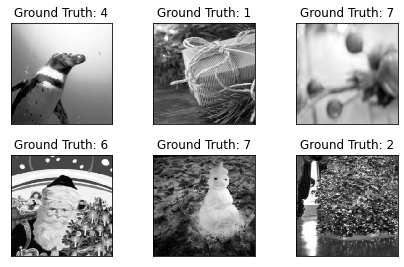

In [7]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

Forward pass

In [12]:

# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

# change the number of classes 
vgg16.classifier[6].out_features = 8
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False
print(vgg16)

cpu
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

Loss calculation

In [13]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

Function for training

In [14]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [15]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

Training

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

Saving the model's weitghts

In [15]:
network.save_model()

Inference

utils.py

In [17]:
import torch
from torch.utils.data import Dataset
import csv
from data import ChristmasImages


class TestSet(Dataset):
    
    def __init__(self, path):
        super().__init__()
        self.dataset = ChristmasImages(path + '/data', training=False)
        
        with open(path + '/val.csv') as file:
            reader = csv.reader(file)
            next(reader)
            labels = {}
            for row in reader:
                labels[int(row[0])] = int(row[1])
        self.labels = labels

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        label = self.labels[idx]
        return image, label


def evaluate(model, loader):
    accuracy = 0.
    with torch.no_grad():
        for image, label in loader:
            _, prediction = model(image).max(dim=1)
            accuracy += (prediction == label).sum().item()
            print("prediction: {},label: {}".format(prediction,label))
    accuracy /= len(loader)
    return accuracy*100


evaluate.py

In [24]:
import torch
from torch.utils.data import DataLoader



# dataset location
path = '/Users/andrewkirubsingh/Desktop/Deeplearning/Challenge/evaluation/dataset'

model = vgg16.eval()
model.load_state_dict(torch.load('TL'))

trainloader_check  = DataLoader(training_set, batch_size = 1, shuffle = True)
#loader = DataLoader(TestSet(path), batch_size=1)



print(evaluate(model, trainloader_check))

prediction: tensor([5]),label: tensor([5])
prediction: tensor([1]),label: tensor([0])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([5])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([6]),label: tensor([5])
prediction: tensor([1]),label: tensor([0])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([1]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([1]),label: tensor([6])
prediction: tensor([2]),label: tensor([3])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([6]),label: tensor([1])
prediction:

prediction: tensor([7]),label: tensor([7])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([0]),label: tensor([6])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([1]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([3]),label: tensor([7])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([7]),label: tensor([4])
prediction:

prediction: tensor([0]),label: tensor([0])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([3]),label: tensor([5])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([0]),label: tensor([6])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([2])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([2]),label: tensor([5])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([6]),label: tensor([6])
prediction:

prediction: tensor([4]),label: tensor([4])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([5]),label: tensor([2])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([5]),label: tensor([5])
prediction:

prediction: tensor([0]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([6])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([3]),label: tensor([2])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([4]),label: tensor([7])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([7])
prediction:

prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([2])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([7]),label: tensor([1])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([2]),label: tensor([7])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([3]),label: tensor([2])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([5]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([0])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([6]),label: tensor([0])
prediction: tensor([7]),label: tensor([7])
prediction:

prediction: tensor([1]),label: tensor([1])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([6]),label: tensor([5])
prediction: tensor([6]),label: tensor([7])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([3]),label: tensor([5])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction:

prediction: tensor([1]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([6]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([0]),label: tensor([6])
prediction: tensor([2]),label: tensor([1])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([1]),label: tensor([0])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([5]),label: tensor([7])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([2]),label: tensor([2])
prediction:

prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([1]),label: tensor([7])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([5])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([6]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction:

prediction: tensor([6]),label: tensor([6])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([7]),label: tensor([5])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([7]),label: tensor([6])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([1]),label: tensor([0])
prediction: tensor([7]),label: tensor([6])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([5]),label: tensor([6])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([0]),label: tensor([2])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([4]),label: tensor([4])
prediction:

prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([6]),label: tensor([1])
prediction: tensor([6]),label: tensor([7])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([1])
prediction: tensor([3]),label: tensor([2])
prediction: tensor([2]),label: tensor([1])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([1])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([1]),label: tensor([0])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([4]),label: tensor([4])
prediction:

prediction: tensor([7]),label: tensor([1])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([3]),label: tensor([7])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([5]),label: tensor([6])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([6]),label: tensor([7])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([7]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction:

prediction: tensor([2]),label: tensor([0])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([6]),label: tensor([1])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([3]),label: tensor([1])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([2]),label: tensor([3])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([5]),label: tensor([4])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([3])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([6])
prediction:

prediction: tensor([4]),label: tensor([4])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([0]),label: tensor([5])
prediction: tensor([5]),label: tensor([0])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction:

prediction: tensor([5]),label: tensor([5])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([7]),label: tensor([5])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([6]),label: tensor([5])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([5]),label: tensor([4])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([6]),label: tensor([5])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([4]),label: tensor([4])
prediction:

prediction: tensor([3]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([3])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([3]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([1])
prediction: tensor([2]),label: tensor([2])
prediction:

prediction: tensor([0]),label: tensor([0])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([5]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([5]),label: tensor([2])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([1])
prediction: tensor([6]),label: tensor([7])
prediction: tensor([6]),label: tensor([7])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([7]),label: tensor([5])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([7])
prediction:

prediction: tensor([4]),label: tensor([4])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([5]),label: tensor([1])
prediction: tensor([1]),label: tensor([4])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([2]),label: tensor([5])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([3]),label: tensor([5])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([7]),label: tensor([7])
prediction:

prediction: tensor([7]),label: tensor([6])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([2]),label: tensor([3])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([5]),label: tensor([6])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([1]),label: tensor([6])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([6]),label: tensor([2])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([4]),label: tensor([5])
prediction: tensor([5]),label: tensor([5])
prediction: tensor([0]),label: tensor([7])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([2]),label: tensor([2])
prediction:

prediction: tensor([5]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([7]),label: tensor([7])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([2]),label: tensor([1])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([1]),label: tensor([1])
prediction: tensor([4]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([2]),label: tensor([7])
prediction: tensor([7]),label: tensor([4])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([6]),label: tensor([6])
prediction: tensor([2]),label: tensor([2])
prediction: tensor([3]),label: tensor([3])
prediction: tensor([0]),label: tensor([0])
prediction: tensor([4]),label: tensor([7])
prediction: tensor([1]),label: tensor([2])
prediction: